In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark

In [ ]:
!pip install matplotlib


In [ ]:
!pip install  seaborn


## **Data Loading and Churn Label Definition :**
### Loads telecom churn data into a PySpark DataFrame, creates a churn label, and displays its distribution.

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

# Initialize Spark session
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Load data
df = spark.read.csv("/content/drive/MyDrive/telecom_churn_data_f.csv", header=True, inferSchema=True)

df.show(5)

# Check churn distribution
df.groupBy("churn").count().show()

+-------------+---------+--------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+-------+-------+-------+-------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------------+------------+------------+------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+------

## **Visualize Churn Distribution**
### Plots a histogram to visualize the churn distribution in the dataset.

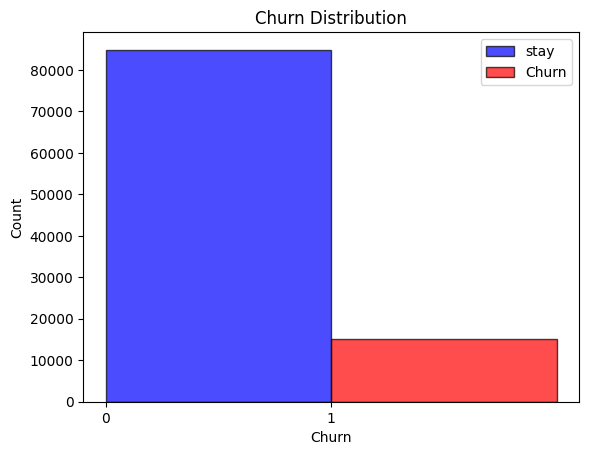

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Convert churn data to Pandas
churn_data = df.select("churn").toPandas()

# Separate data for churn values 0 and 1
stay= churn_data[churn_data["churn"] == 0]["churn"]
churn = churn_data[churn_data["churn"] == 1]["churn"]

# Plot histograms for churn 0 and churn 1 with different colors
plt.hist(stay, bins=np.arange(0, 2 + 1 , 1), color='blue', alpha=0.7, edgecolor='black', label='stay')
plt.hist(churn, bins=np.arange(0, 2 + 1 , 1), color='red', alpha=0.7, edgecolor='black', label='Churn')


plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.xticks([0,1])
plt.legend()
plt.show()

## **Handle Missing Data:**
### Drops columns with more than 50% missing values, retains valid columns, and fills missing values with column means.

In [11]:
from pyspark.sql.functions import mean, col

# Step 1: Filter columns with valid types
valid_data_types = {'int', 'double', 'long', 'float', 'decimal', 'string', 'timestamp', 'boolean'}
valid_cols = [field.name for field in df.schema.fields if field.dataType.simpleString() in valid_data_types]

# Step 2: Drop columns with too many missing values
threshold = df.count() * 0.5
valid_cols = [col for col in valid_cols if df.filter(df[col].isNotNull()).count() > threshold]
df = df.select(valid_cols)

# Step 3: Fill missing values with mean for numeric columns
for column in df.columns:
    if df.select(column).dtypes[0][1] in ['double', 'int']:
        mean_value = df.select(mean(col(column))).collect()[0][0]
        df = df.fillna({column: mean_value})

# Show the final DataFrame
df.show(5)


+---------+--------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+-------+-------+-------+-------+------------------+------------------+-----------+-----------------+----------------+------------------+------------+------------------+-----------------+----------------+-------------+-----------------+-----------------+-----------------+-------------+----------------+-----------------+------------------+----------------+----------------+-----------------+-----------------+----------------+-----------------+------------------+------------------+----------------+-----------------+------------------+------------------+----------------+----------------+------------------+------------------+------------+------------------+----------------+-----------------+----------------+-----------------+-----------------+-----------------+----------------+-----------------+------------------+------------------+----------------+-----

## **Feature Engineering and Scaling**
### Creates aggregate features for average  total voice in mounthge and normalizes numerical columns using MinMaxScaler.

In [20]:
from pyspark.sql.functions import col

# Add avg_total_voice_mou_6
df = df.withColumn("avg_total_voice_mou_6",
                   (col("onnet_mou_6") + col("offnet_mou_6")) / 2)

# Add avg_total_voice_mou_7
df = df.withColumn("avg_total_voice_mou_7",
                   (col("onnet_mou_7") + col("offnet_mou_7")) / 2)

# Add avg_total_voice_mou_8
df = df.withColumn("avg_total_voice_mou_8",
                   (col("onnet_mou_8") + col("offnet_mou_8")) / 2)




# Normalize numerical columns
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

numeric_cols = ["avg_total_voice_mou_6", "avg_total_voice_mou_7", "avg_total_voice_mou_8",
            "total_rech_amt_6", "total_rech_amt_7", "total_rech_amt_8"]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

df = assembler.transform(df)
df = scaler.fit(df).transform(df)


## **Train-Test Split**
### Splits the data into training and testing sets .

In [21]:
# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)


## **Random Forest Model Training and Evaluation**
### Trains a Random Forest model, makes predictions, and evaluates it using AUC.

In [22]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the model
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaled_features")

# Train the model
rf_model = rf.fit(train_df)

# Make predictions
predictions = rf_model.transform(test_df)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="churn")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")


AUC: 0.7897477160696115


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


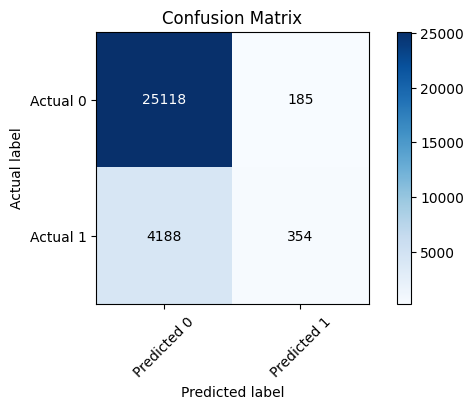

In [28]:

from pyspark.mllib.evaluation import BinaryClassificationMetrics # Import the necessary class

# Convert predictions to RDD for BinaryClassificationMetrics
predictionAndLabels = predictions.select("prediction", "churn").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = BinaryClassificationMetrics(predictionAndLabels)

# --- Confusion Matrix ---
# Calculate confusion matrix
tp = predictions.filter((predictions.churn == 1) & (predictions.prediction == 1)).count()
tn = predictions.filter((predictions.churn == 0) & (predictions.prediction == 0)).count()
fp = predictions.filter((predictions.churn == 0) & (predictions.prediction == 1)).count()
fn = predictions.filter((predictions.churn == 1) & (predictions.prediction == 0)).count()

# Create confusion matrix
confusion_matrix = np.array([[tn, fp], [fn, tp]])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Predicted 0', 'Predicted 1'], rotation=45)
plt.yticks(tick_marks, ['Actual 0', 'Actual 1'])
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
for i, j in np.ndindex(confusion_matrix.shape):
    plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='white' if confusion_matrix[i, j] > confusion_matrix.max() / 2 else 'black')
plt.show()



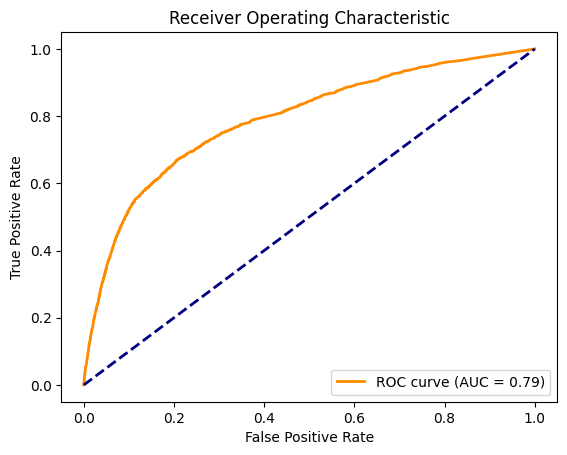

In [27]:
from sklearn.metrics import roc_curve, auc

# Extract probability and true labels
probabilities = predictions.select("probability", "churn").toPandas()
y_true = probabilities["churn"]
y_scores = probabilities["probability"].apply(lambda x: x[1])  # Probability of class 1

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


## **Feature Importance Extraction**
### Extracts and displays feature importance from the trained Random Forest model.

In [23]:
# Extract feature importances
importances = rf_model.featureImportances
print("Feature Importances:", importances)

Feature Importances: (6,[0,1,2,3,4,5],[0.25773712310385255,0.145536453826006,0.08056492733961092,0.29546682138709945,0.12945309596641547,0.09124157837701574])


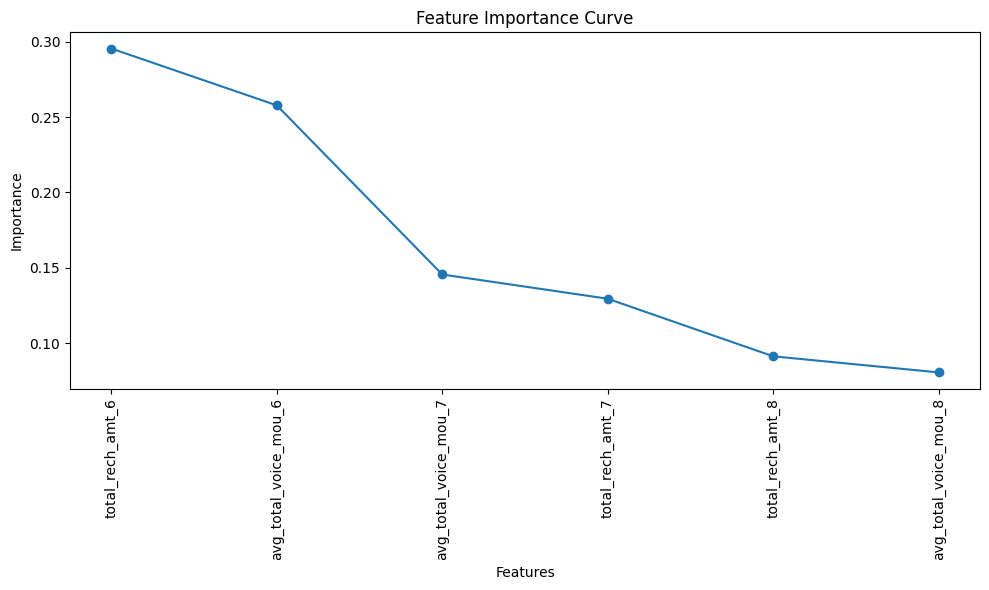

In [24]:
importance_df = pd.DataFrame({'Feature': numeric_cols, 'Importance': importances.toArray()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance curve
plt.figure(figsize=(10, 6))
plt.plot(importance_df['Feature'], importance_df['Importance'], marker='o', linestyle='-')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Curve')
plt.tight_layout()
plt.show()